In [11]:
from environment import Environment
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

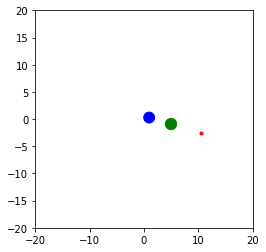

In [12]:
BATCH_SIZE = 100
LR = 0.01
GAMMA = 0.90
EPSILON = 0.9
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 1000

env = Environment()
env.draw_map()
NUM_ACTIONS = env.n_actions
NUM_STATES = env.n_features
EPISODES = 50000

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, NUM_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [14]:
class DQN:
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        self.loss = nn.MSELoss()

    def store_trans(self, state, action, reward, next_state):
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, action, reward, next_state))
        self.memory[index, :] = trans
        self.memory_counter += 1

    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0)
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action

    def learn(self):
        if self.learn_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

The DQN is collecting experience...


  0%|          | 0/50000 [00:00<?, ?it/s]

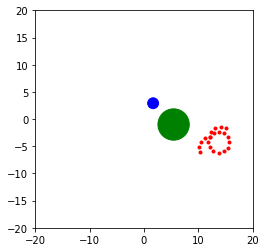

 40%|████      | 20000/50000 [07:45<10:23, 48.08it/s]

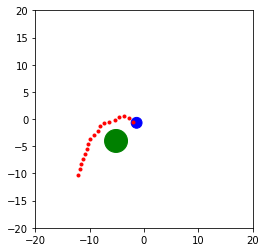

 80%|███████▉  | 39998/50000 [14:41<03:35, 46.52it/s]

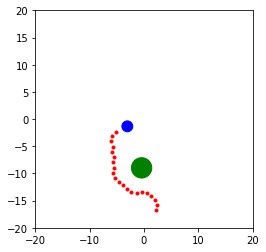

100%|██████████| 50000/50000 [18:16<00:00, 45.58it/s]


In [15]:
rewards = []
net = DQN()

def main():
    print("The DQN is collecting experience...")
    step_counter_list = []
    for episode in tqdm.tqdm(range(EPISODES)):
        state = env.reset()
        step_counter = 0
        sum_rew = 0
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = env.step(action)
            # sum_rew += reward
            net.store_trans(state, action, reward, next_state)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
            if done:
                step_counter_list.append(step_counter)
                rewards.append(reward)
                if episode % 20000 == 0:
                    env.draw_map()
                break

            state = next_state


if __name__ == '__main__':
    main()

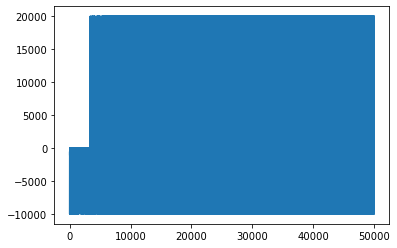

In [16]:
import matplotlib.pyplot as plt

plt.plot(rewards)

In [17]:
p = 0
for i in rewards:
    if i > 0:
        p += 1

print(p)

28814


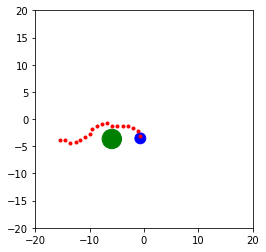

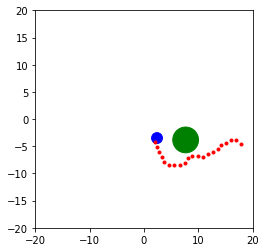

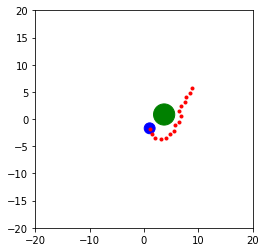

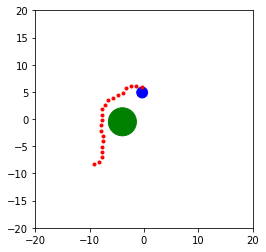

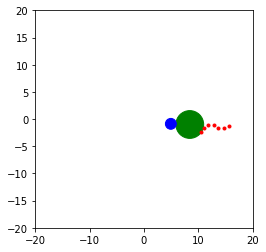

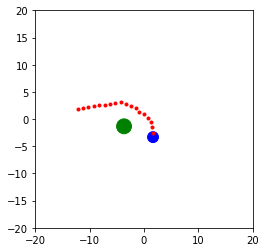

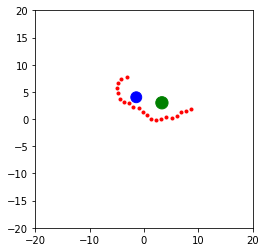

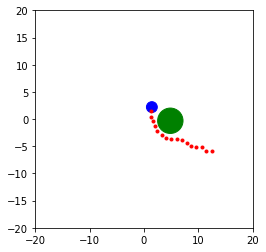

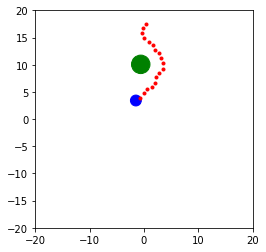

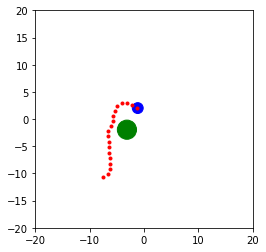

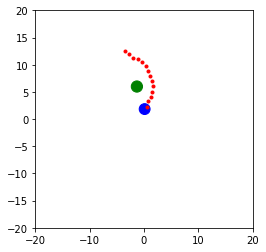

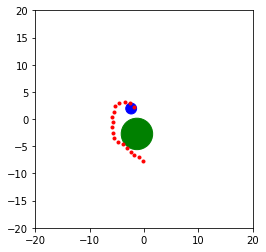

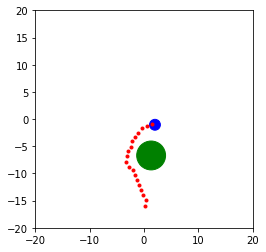

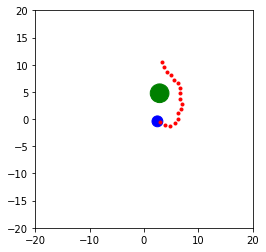

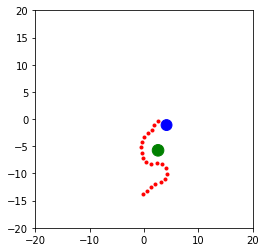

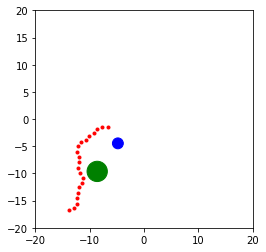

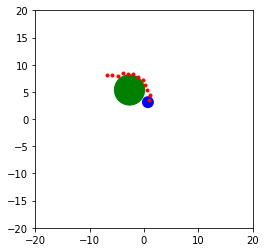

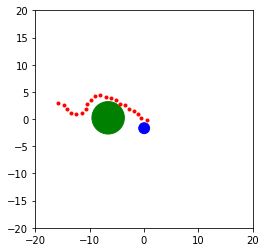

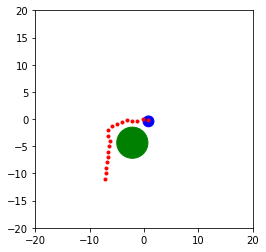

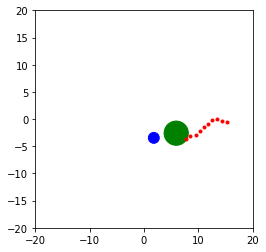

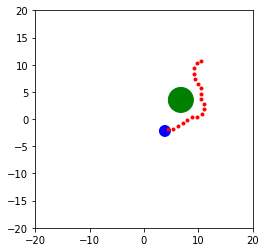

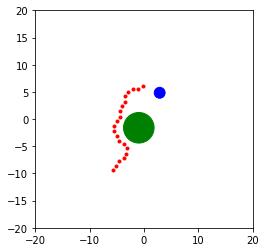

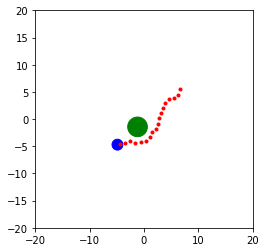

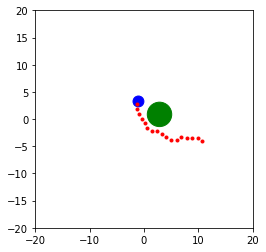

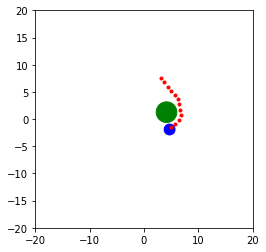

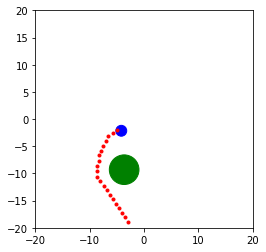

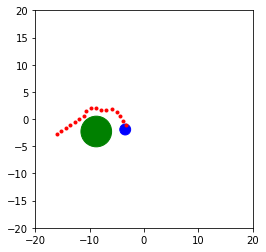

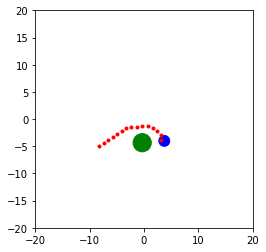

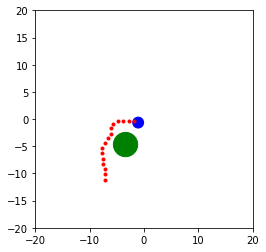

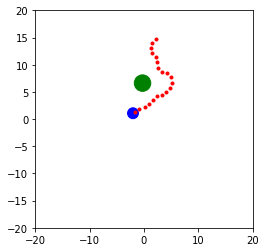

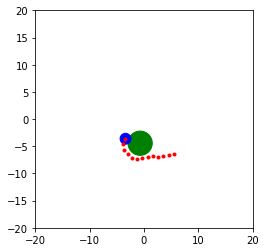

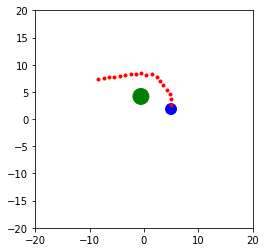

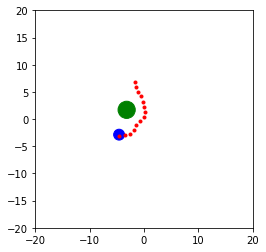

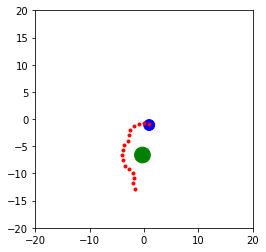

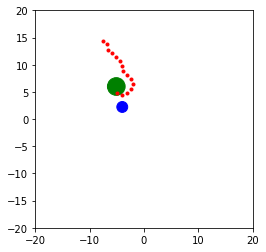

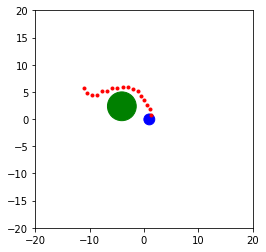

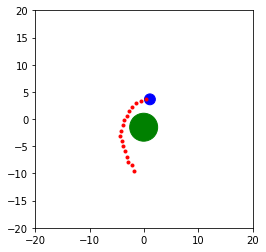

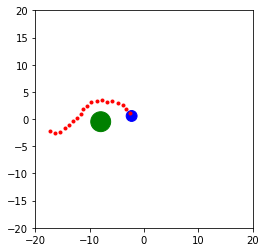

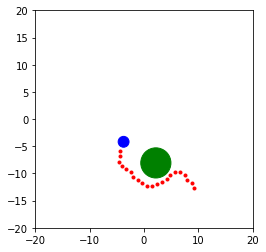

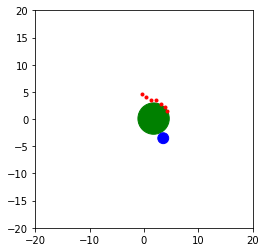

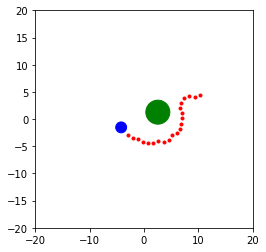

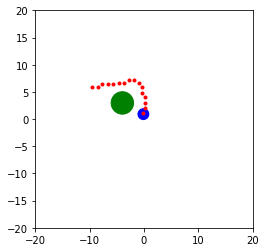

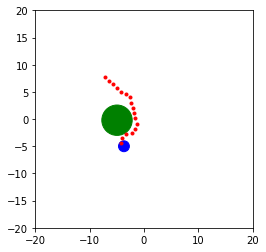

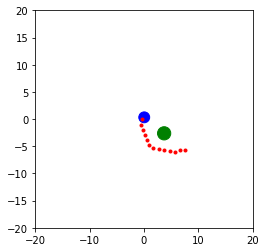

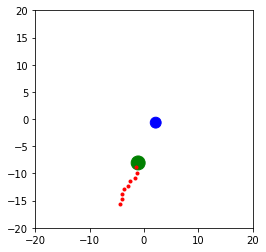

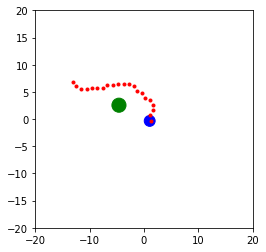

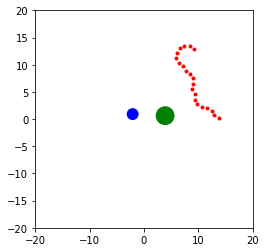

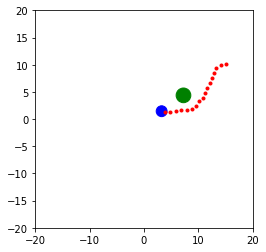

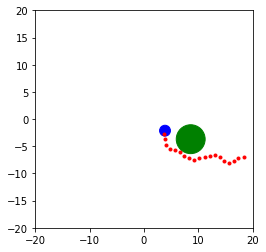

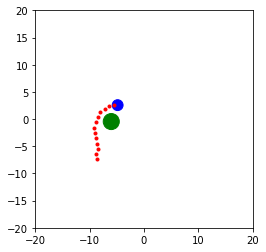

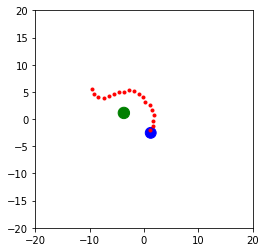

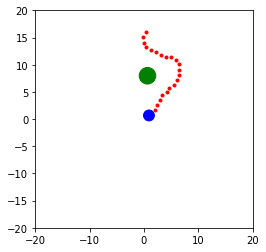

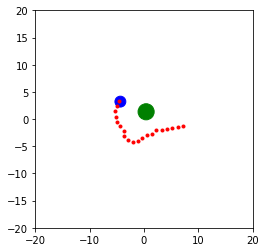

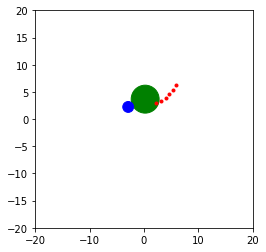

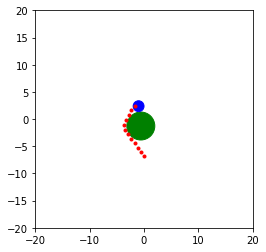

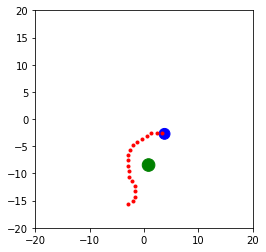

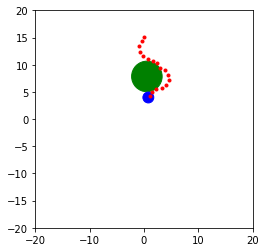

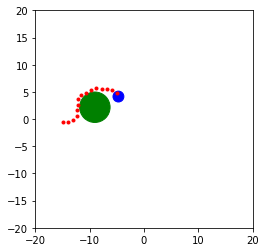

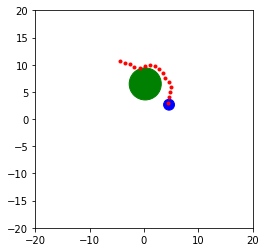

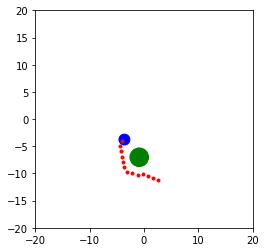

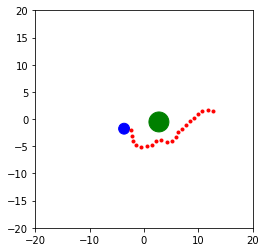

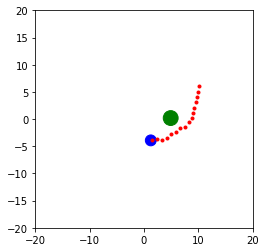

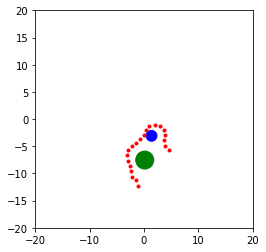

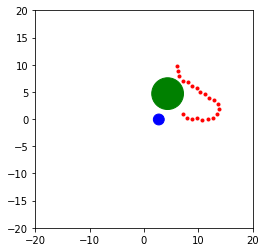

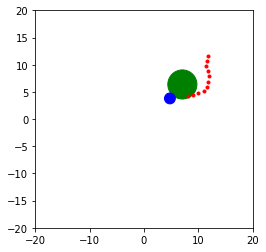

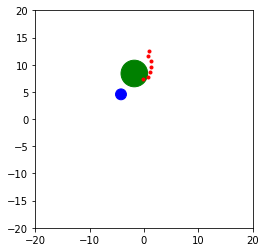

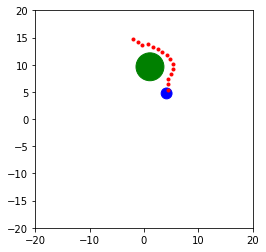

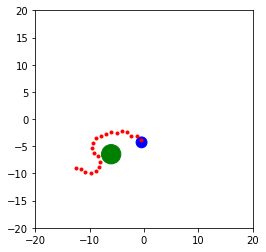

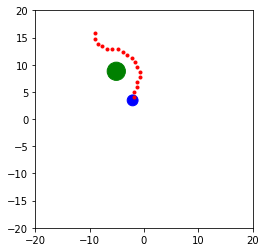

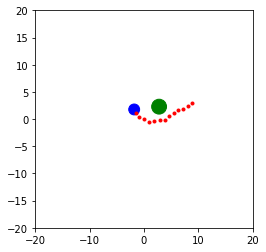

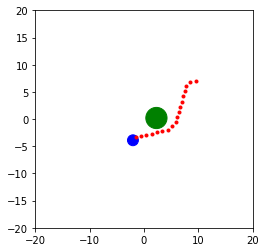

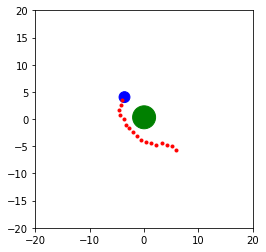

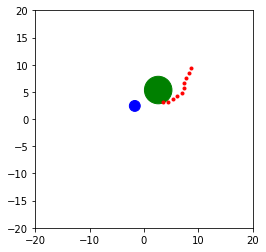

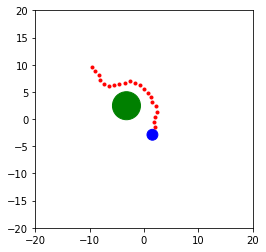

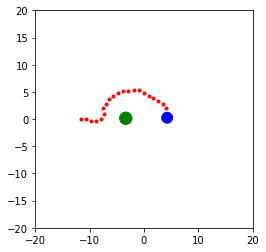

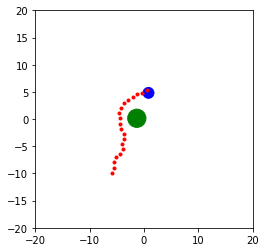

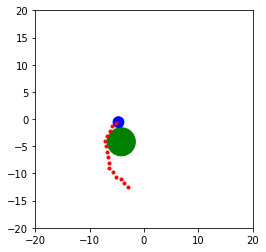

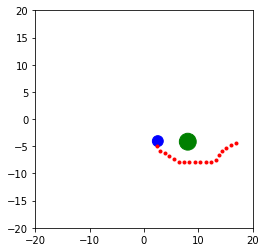

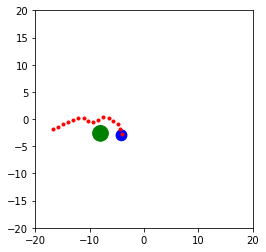

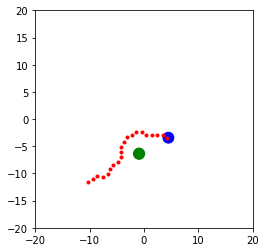

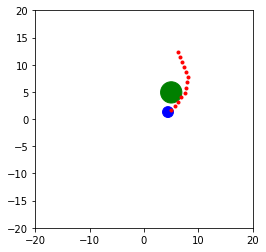

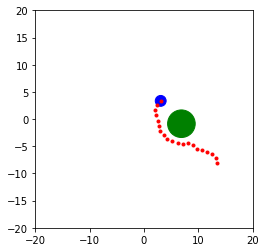

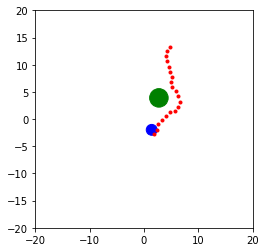

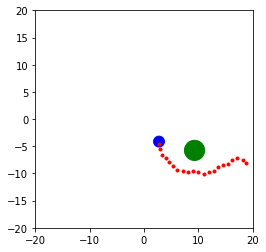

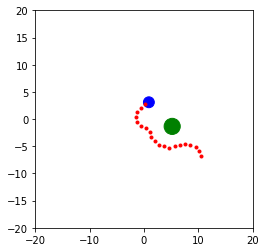

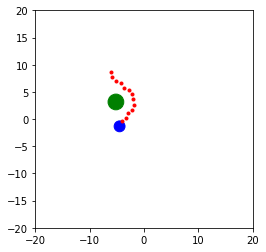

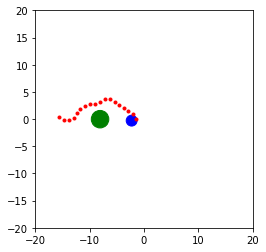

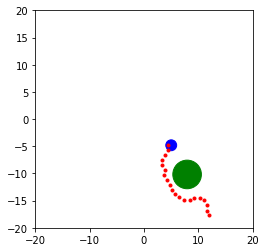

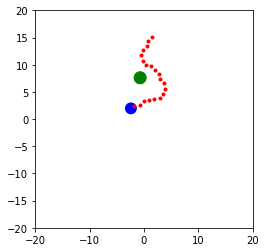

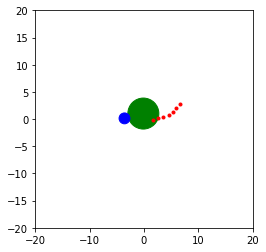

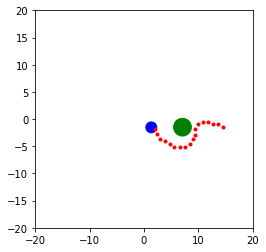

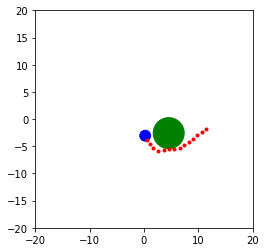

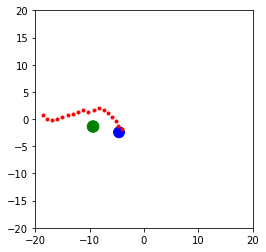

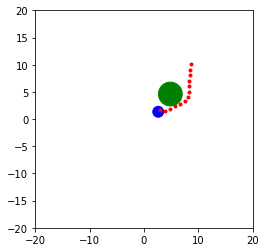

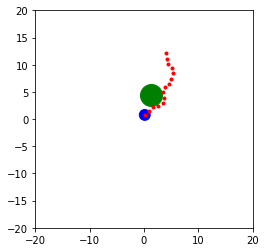

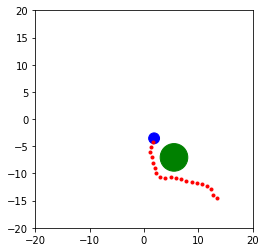

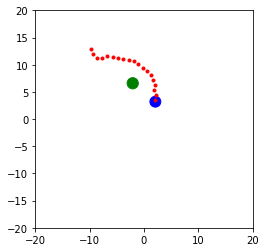

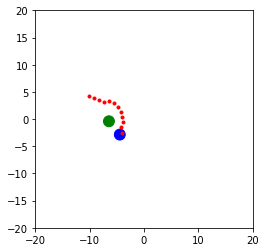

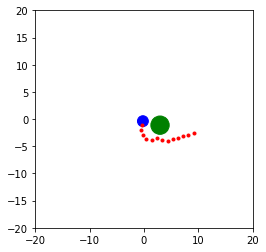

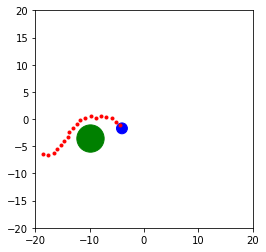

In [18]:
rewards = []
for i in range(100):
    test_env = Environment()
    state = test_env.get_state()
    while True:
        action = net.choose_action(state)
        next_state, reward, done = test_env.step(action)
        net.store_trans(state, action, reward, next_state)
        if done:
            rewards.append(reward)
            test_env.draw_map()
            break
        state = next_state

In [19]:
p = 0
for i in rewards:
    if i > 0:
        p += 1

print(p)

75


In [10]:
print(rewards)

[-10000, 20000, 20000, 20000, -10000, 20000, 20000, 20000, -10000, 20000, 20000, 20000, 20000, -816.4615232213552, 20000, 20000, 20000, -10000, 20000, 20000, 20000, 20000, -852.2013478404714, 20000, -998.1967471946158, -10000, -10000, 20000, 20000, -990.281151741487, 20000, 20000, -10000, 20000, 20000, 20000, 20000, -53.01210600402466, 20000, 20000, 20000, 20000, 20000, 20000, -10000, -10000, 20000, 20000, -10000, -230.66949260870686, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, -10000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, -10000, -10000, 20000, -10000, 20000, -936.4686353941205, 20000, 20000, -10000, -10000, -10000, 20000, 20000, 20000, 20000, -10000, 20000, 20000, 20000, -240.2222893305208, 20000, 20000, 20000, 20000, 20000, 20000, -10000, -10000, 20000, 20000]
